# Part 3 - Calculation of the Period and overall Transit Time 

In [1]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema
import emcee

import corner
import scipy as sp
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

In [2]:
physical = pd.read_excel('Physical.xlsx', sheetname='Sheet1')
targetParams = pd.read_excel('Results.xlsx', sheetname='TAP')


class Star:    
    def __init__(self, name, midts, per, per_err, mass, mass_err, radius,
                 radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp,timeLC, fluxLC):
        
        self.name = name
        self.midts = midts
        self.ecc = 0.0
        self.per = per
        self.per_err = per_err
        
        self.mass = mass
        self.mass_err = mass_err
        self.radius = radius
        self.radius_err = radius_err
        
        self.teff = teff
        self.teff_err = teff_err
        self.logg = logg
        self.feh = feh
        
        self.b = b
        self.b_err = b_err
        self.rprs = rprs
        self.depth = rprs ** 2 # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
        
        self.rp = rp #Earth radii
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. Rp needs to be in Earth radii
        
        #self.lld = lld # Linear LD coeff (Joey)
        #self.qld = qld # Quadratic LD coeff (Joey)  
        
        self.u1 = 0.0 # Claret
        self.u2 = 0.0 # Claret
        self.diffld = u2 - u1
        
        self.timeLC = timeLC
        self.fluxLC = fluxLC
        
        self.transits = np.empty(0)
        self.transRange = np.empty(0)
        self.transWindow = np.empty(0)
        self.flag = np.empty(0)
        self.f_trans = np.empty(0)
        self.t_trans = np.empty(0)
        self.dt = np.empty(0)
        self.error_foldedLC = np.empty(0)
        
        self.optimize1 = np.empty(0)
       
        self.p_final = 0.0
        self.t0_final = 0.0
        
    def Print(self):
        print("Star {}".format(self.name))

In [3]:
num = 12

In [4]:
tKep = 29.42/(60.0*24.0)
transit_range = np.array([0.4, 0.18, 0.07, 0.15, 0.12, 0.07, 0.08, 0.12, 0.15, 0.08, 0.18, 0.15])
tr_window = transit_range+transit_range # In days

In [20]:
targets = []
for i in range(0,num):
    name = "%.0f" % targetParams["EPIC"][i]
    midts = targetParams["midts"][i]
    per = targetParams["per"][i] #days
    
    per_lo = targetParams["per_lo"][i]
    per_hi = targetParams["per_hi"][i]
    per_err = np.mean([per_lo, per_hi])
    
    # Stellar mass
    mass = physical["mass"][i]
    mass_lo = physical["mass_lo"][i]
    mass_hi = physical["mass_hi"][i]
    mass_err = np.mean([mass_lo, mass_hi])
    
    # Stellar radius 
    radius = physical["radius"][i]
    radius_lo = physical["radius_lo"][i]
    radius_hi = physical["radius_hi"][i]
    radius_err = np.mean([radius_lo, radius_hi])
    
    #Effective temperature (In Kelvin)
    teff = physical["Teff"][i]
    teff_lo = physical["Teff_lo"][i]
    teff_hi = physical["Teff_hi"][i]
    teff_err = np.mean([teff_lo, teff_hi])
    
    #Logg
    logg = physical["logg"][i]
    feh = physical["feh"][i]
    
    # Impact parameter b
    b = targetParams["b"][i]
    b_lo = targetParams["b_lo"][i]
    b_hi = targetParams["b_hi"][i]
    b_err = np.mean([b_lo, b_hi])
        
    rprs = targetParams["rp/rs"][i] # Ratio Rp/Rs
    rprs_lo = targetParams["rp/rs_lo"][i]
    rprs_hi = targetParams["rp/rs_hi"][i]
    rprs_err = np.mean([rprs_lo, rprs_hi])
    
    rp = targetParams["rp"][i] # Planetary radius (Earth radii)
    
    u1 = 0.0
    u2 = 0.0
    
    #lld = targetParams["LLD"][i] # Linear 
    #qld = targetParams["QLD"][i] # Quadratic
    
    # This will upload LC data
    data = pd.read_table(name+"transits.csv", sep=',', dtype = {'flux': np.float64}, header = None, names=['time', 'flux'])
    
    timeLC = data['time']
    fluxLC = data['flux']

    trange = transit_range[i]
    twind = tr_window[i]
 
    star = Star(name, midts, per, per_err, mass, mass_err, radius, 
               radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp, timeLC, fluxLC)
    
    # Note: THE PARAMETERS BELOW ARE DIFFERENT (transwindow = 2*transrange)
    star.transRange = trange
    star.transWindow = twind 
     
    targets.append(star)

In [21]:
import kplr
from kplr.ld import get_quad_coeffs

def quadraticLD(star): #Model: Claret 2011.
    """
    Get the quadratic coefficients for the standard Kepler limb-darkening
    profile.
    
    :param teff: The effective temperature in degrees K.
    :param logg: The log10 surface gravity in cm/s/s.
    :param feh: The metallicity [Fe/H].
        
    """
    getmu1, getmu2 = get_quad_coeffs(star.teff, star.logg, star.feh)
    return getmu1, getmu2


print "  ***  Quadratic Limb Darkening Coefficients: u1, u2, diffLD (u2-u1)  *** "
print ""

for star in targets:
    mu1, mu2 = quadraticLD(star)
    print "Star", star.name, ":", mu1, mu2, mu1-mu2
    star.u1 = mu1
    star.u2 = mu2
    star.diffLD = mu1-mu2

  ***  Quadratic Limb Darkening Coefficients: u1, u2, diffLD (u2-u1)  *** 

Star 201516974 : 0.7867 -0.0114 0.7981
Star 201920032 : 0.4089 0.2556 0.1533
Star 205924614 : 0.678 0.0894 0.5886
Star 205985357 : 0.4415 0.2396 0.2019
Star 206029314 : 0.4906 0.1813 0.3093
Star 206038483 : 0.4089 0.2556 0.1533
Star 206061524 : 0.6656 0.0853 0.5803
Star 206082454 : 0.3858 0.2711 0.1147
Star 206155547 : 0.3277 0.2981 0.0296
Star 206245553 : 0.3643 0.2807 0.0836
Star 206247743 : 0.5362 0.1609 0.3753
Star 206311743 : 0.5508 0.1646 0.3862


In [8]:
def processStar(star):
    goodP = intro(star)  
    mark_transits(star)
    transit_window(star, goodP)
    print "Nº of transits (theory):", len(star.transits)
    out_trans = out_transit(star)
    oot_fit(star)
    print "Nº of transits (observed):", len(star.transits)

In [22]:
def intro(star):
    errorLC = np.std(star.fluxLC)
    meanFlux = np.mean(star.fluxLC)
    goodPoints = star.fluxLC <= meanFlux+3*errorLC
    return goodPoints

In [23]:
def mark_transits(star):
    
    minTime = min(star.timeLC)
    maxTime = max(star.timeLC)
       
    def my_range(start, end, step):
        while start <= end:
            yield start
            start += step
      
    minepoch = -20
    maxepoch = 20
    numepochs = maxepoch-minepoch+1
    
    transitLoc = np.empty(numepochs)

    for x in my_range(minepoch, maxepoch, 1):
        transit = star.midts+x*star.per
        transitLoc[x-minepoch]=transit

    goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
    transits = transitLoc[goodTrans] # Stores transit times
    
    star.transits = transits
    
def transit_window(star, goodP):
    t = star.timeLC[goodP]
    f = star.fluxLC[goodP]
    
    window = star.transWindow # In days
    sumPoints = 0
     
    for i in range(0,len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0, len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = t[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = f[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.f_trans = f_trans
    star.t_trans = t_trans 
    star.dt = dT

In [24]:
def out_transit(star):
    #print "Range of the transit (visual estimate):", star.transRange
    dataBool = np.abs(star.dt) >= star.transRange # If true, point is outside of the transit.
    out = (star.t_trans <= star.transRange) & (star.t_trans >= star.transRange) # Boolean array. Tells which points are outside the transit.
    return out

In [25]:
def oot_fit(star): 
    
    corFlux = star.f_trans
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        
        if len(star.dt[outsideBool] != 0): 
            z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
            p = np.poly1d(z)
            corFlux[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) # Divide transit by fit.
        
        else: 
            star.transits[i] = 0.0
   
    # ------- Fix length of star.transits vector (if necessary) ------- 
    
    new_a = np.empty(0)
     
    for k in range(0,len(star.transits)):
        if star.transits[k] != 0.0:
            new_a = np.append(new_a, star.transits[k])
   
    star.transits = new_a
    
    # ------- Fix length of star.flag, star.f_trans, star.t_trans, and star.dt vectors (if necessary)
    
    sumPoints = 0
    
    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.t_trans[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.f_trans[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.t_trans = t_trans 
    star.f_trans = f_trans 
    star.dt = dT
    
    # Correct Flux again (needed if we had to some star.transits didn't have data)
    
    corFlux2 = star.f_trans
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
        p = np.poly1d(z)
        corFlux2[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) 
    
    #Calculate the standard dev. of the folded LC 
    
    star.f_trans = corFlux2
    
    outside_foldedLC = np.abs(star.dt) >= star.transRange
    err_folded = np.std(corFlux2[outside_foldedLC])
    star.error_foldedLC = err_folded

In [26]:
new_targets = np.empty(0)

for i in range(0, len(targets)):    
    if (targets[i].name != "205985357") and (targets[i].name != "206038483") and (targets[i].name != "206247743") and (targets[i].name != "206311743"):
        new_targets = np.append(new_targets, targets[i])
        
for star in new_targets:
    print "Star ", star.name

print len(new_targets)

#  205985357: False Positive
#  206038483: Missing 2 transits....
#  206247743: False Positive 
#  206311743: False Positive

Star  201516974
Star  201920032
Star  205924614
Star  206029314
Star  206061524
Star  206082454
Star  206155547
Star  206245553
8


In [27]:
for star in new_targets:
    print "   Target ", star.name  
    print ""
    processStar(star)
    print ""
    print "-----------------------------------------------------------------"

   Target  201516974

Nº of transits (theory): 2
Nº of transits (observed): 2

-----------------------------------------------------------------
   Target  201920032

Nº of transits (theory): 3
Nº of transits (observed): 3

-----------------------------------------------------------------
   Target  205924614

Nº of transits (theory): 21
Nº of transits (observed): 19

-----------------------------------------------------------------
   Target  206029314

Nº of transits (theory): 10
Nº of transits (observed): 10

-----------------------------------------------------------------
   Target  206061524

Nº of transits (theory): 11
Nº of transits (observed): 9

-----------------------------------------------------------------
   Target  206082454

Nº of transits (theory): 2
Nº of transits (observed): 2

-----------------------------------------------------------------
   Target  206155547

Nº of transits (theory): 3
Nº of transits (observed): 3

----------------------------------------------

## Determine the orbital period and the midtransit time

Initial guess: Linear fit of individual transit times.
Improve calculation with Levenberg–Marquardt algorithm

In [28]:
def func(x, a, b): 
    return (a*x + b)

def oc(star, obst0, upper_error, lower_error):
    aux = 0
    
    # Find if there are any missing transits
    
    print "  -> Time diff b/w consecutive transits/period (t/p):"
    
    for i in range (0, len(star.transits)):
        timediff = obst0[i]-obst0[i-1]
        missing_transits = round(timediff/star.per) #if numtransits = 2, then there's a missing transit. If 3, there will be 3. 
        
        if i == 0: 
            missing_transits = 1.0
        
        print "      Transit nº", i+1, ": t/p = ", missing_transits
        aux = aux + missing_transits 
    
    num_obs = len(star.transits)
    num_theo = aux
    missing = num_theo-num_obs
    print ""
    print "  -> Nº of missed Transits: ", missing
    
    # If nº of theoretical transits is the same as the nº of observed transits
    
    if num_theo == num_obs: 
        n = np.empty(len(star.transits))
        tobs = np.empty(len(star.transits))
        tobsErr = np.empty(len(star.transits))
         
        for i in range(0, len(n)):
            n[i] = i
        
        for i in range (0, len(star.transits)):
            aux = obst0[i]    
            auxerr = (upper_error[i] + lower_error[i])/2 
            tobs[i] = aux
            tobsErr[i] = auxerr 
        
        tobs = np.array(tobs)
        tobsErr = np.array(tobsErr)

    # If nº of theoretical transits does NOT match the nº of observed transits
    
    if num_theo != num_obs:   
        newsize = int(len(star.transits) + missing)
        print "  -> Nº of Theoretical Transits:", newsize
        
        tobs = np.zeros(newsize)
        tobsErr = np.zeros(newsize)
        err_observedt0 = []
        observedt0 = []
       
        print "  -> When are the missing transits?:"
        print ""
        
        for i in range(0, len(star.transits)):    
            timediff = obst0[i]-obst0[i-1]
            missedTrans = round(timediff/star.per) #if missedTrans = 2, then there's a missing transit. If 3, there will be 2. 
            
            if i == 0: 
                missedTrans = 1.0
            
            err_observedt0.append((upper_error[i] + lower_error[i])/2)
            
            if missedTrans != 1.0:
                time_missing = obst0[i-1] + (missedTrans-1)*star.per
                print "        ", time_missing
                observedt0.append(time_missing)
                err_observedt0.append(mean_error)
                lower_error = np.insert(lower_error, i, mean_error)
                upper_error = np.insert(upper_error, i, mean_error)
                
            observedt0.append(obst0[i])
            mean_error = np.mean([np.mean(upper_error), np.mean(lower_error)])
            
        n = np.empty(newsize)
        
        for i in range(0, len(n)):
             n[i] = i
      
        tobs = np.array(observedt0)
        tobsErr = np.array(err_observedt0)
        
    print ""
    print "  -> 'Observed' t0 (inlcuding missing transits if applicable):"
    print tobs
    print ""
    print "  -> Error of observed t0 (note: 0.0 values correspond to missing transits):"
    print tobsErr
    print ""

    print "Check that  vectors n and tobs have same length:", len(n), len(tobs)

    # Linear fit of observed transit times (plus missed transits if applicable)
    
    k = np.polyfit(n, tobs, 1) 
    slopeP = k[0]
    t0Final = k[1]
    p0 = [slopeP, t0Final] #Initial guesses
   
    print "  -> Initial Guesses (from linear fit of observed t0):"
    print "        Period = ", slopeP, "days"
    print "        t0 = ", t0Final
    print ""
   
    # Curve_fit uses Levenberg–Marquardt_algorithm
    
    popt, pcov = op.curve_fit(func, n, tobs, p0 = [slopeP, t0Final], sigma = tobsErr) 
    perr = np.sqrt(np.diag(pcov)) #Entry 0 = Error of period; Entry 1 = Error of t0
    
    """
        popt: ptimal values for the parameters so that the sum of the squared error of 
        "f(xdata, *popt) - ydata" is minimized. (Array) 

        pcov: The estimated covariance of popt. The diagonals provide the variance of the parameter 
        estimate. To compute one standard deviation errors on the parameters use 
        err = np.sqrt(np.diag(pcov)). (2D Array)
    """
        
    if len(star.transits) == 2: # With 2 points, we can't calculate the error
        perr[0] = 0.0
        perr[1] = 0.0 
    
    print "perr: ", perr
    print "  -> Optimal Values:"
    print ""
    print "        Period = ", popt[0], "+/-", perr[0]
    print "        Transit Time = ", popt[1], "+/-", perr[1]
    print " "
    
    # Calculate O-C: o-c = t obs(n) - t0 - P*n'
    o_c = np.array(tobs) - popt[1] - popt[0]*np.array(n) # 
    
    asymmetric_error = [lower_error, upper_error]
 
    print "Length of 'upper' & 'lower' error", len(lower_error), len(upper_error)
       
    plt.figure()
    plt.errorbar(tobs, o_c, yerr = asymmetric_error, fmt='o')
    plt.xlabel('T obs(n)')
    plt.ylabel('O-C Residuals (days)') #Residuals t obs(n) - t0 - P*n'
    plt.title('Residuals for Star '+ star.name, fontsize = 15)
    plt.show()

    return popt, perr

************************ Star 201516974  ************************

  -> Number of observed transits: 2
  -> Observed transit times:
[ 1986.79404608  2023.51523943]

  -> Time diff b/w consecutive transits/period (t/p):
      Transit nº 1 : t/p =  1.0
      Transit nº 2 : t/p =  1.0

  -> Nº of missed Transits:  0.0

  -> 'Observed' t0 (inlcuding missing transits if applicable):
[ 1986.79404608  2023.51523943]

  -> Error of observed t0 (note: 0.0 values correspond to missing transits):
[ 0.00684761  0.00636665]

Check that  vectors n and tobs have same length: 2 2
  -> Initial Guesses (from linear fit of observed t0):
        Period =  36.72119335 days
        t0 =  1986.79404608

perr:  [ 0.  0.]
  -> Optimal Values:

        Period =  36.72119335 +/- 0.0
        Transit Time =  1986.79404608 +/- 0.0
 
Length of 'upper' & 'lower' error 2 2


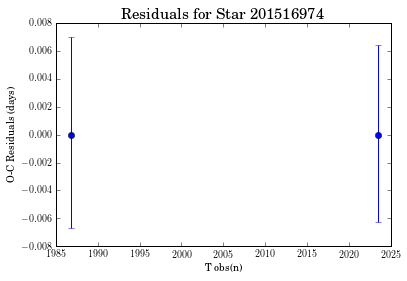

************************ Star 201920032  ************************

  -> Number of observed transits: 3
  -> Observed transit times:
[ 2000.20713219  2028.46827323  2056.74827125]

  -> Time diff b/w consecutive transits/period (t/p):
      Transit nº 1 : t/p =  1.0
      Transit nº 2 : t/p =  1.0
      Transit nº 3 : t/p =  1.0

  -> Nº of missed Transits:  0.0

  -> 'Observed' t0 (inlcuding missing transits if applicable):
[ 2000.20713219  2028.46827323  2056.74827125]

  -> Error of observed t0 (note: 0.0 values correspond to missing transits):
[ 0.00387158  0.0070195   0.00505997]

Check that  vectors n and tobs have same length: 3 3
  -> Initial Guesses (from linear fit of observed t0):
        Period =  28.27056953 days
        t0 =  2000.20398936

perr:  [ 0.00387358  0.00458367]
  -> Optimal Values:

        Period =  28.2701484859 +/- 0.00387357558055
        Transit Time =  2000.20594302 +/- 0.00458366744451
 
Length of 'upper' & 'lower' error 3 3


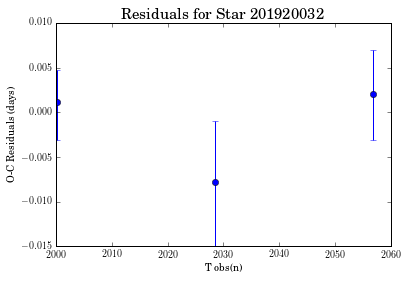

************************ Star 206029314  ************************

  -> Number of observed transits: 10
  -> Observed transit times:
[ 2148.06908178  2155.09510053  2162.11975672  2169.14633415  2176.17259045
  2183.19751282  2190.22350755  2197.25011366  2204.27617914  2211.30198284]

  -> Time diff b/w consecutive transits/period (t/p):
      Transit nº 1 : t/p =  1.0
      Transit nº 2 : t/p =  1.0
      Transit nº 3 : t/p =  1.0
      Transit nº 4 : t/p =  1.0
      Transit nº 5 : t/p =  1.0
      Transit nº 6 : t/p =  1.0
      Transit nº 7 : t/p =  1.0
      Transit nº 8 : t/p =  1.0
      Transit nº 9 : t/p =  1.0
      Transit nº 10 : t/p =  1.0

  -> Nº of missed Transits:  0.0

  -> 'Observed' t0 (inlcuding missing transits if applicable):
[ 2148.06908178  2155.09510053  2162.11975672  2169.14633415  2176.17259045
  2183.19751282  2190.22350755  2197.25011366  2204.27617914  2211.30198284]

  -> Error of observed t0 (note: 0.0 values correspond to missing transits):
[ 0.00085

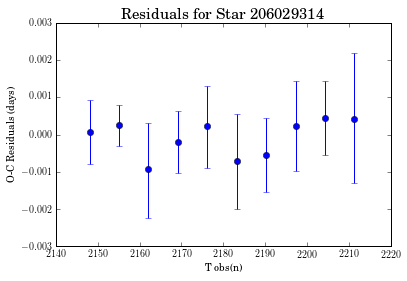

************************ Star 206061524  ************************

  -> Number of observed transits: 9
  -> Observed transit times:
[ 2153.32299145  2159.20336903  2165.0836464   2170.96297081  2176.84282802
  2188.60190302  2194.4780631   2206.23771337  2212.12359028]

  -> Time diff b/w consecutive transits/period (t/p):
      Transit nº 1 : t/p =  1.0
      Transit nº 2 : t/p =  1.0
      Transit nº 3 : t/p =  1.0
      Transit nº 4 : t/p =  1.0
      Transit nº 5 : t/p =  1.0
      Transit nº 6 : t/p =  2.0
      Transit nº 7 : t/p =  1.0
      Transit nº 8 : t/p =  2.0
      Transit nº 9 : t/p =  1.0

  -> Nº of missed Transits:  2.0
  -> Nº of Theoretical Transits: 11
  -> When are the missing transits?:

         2182.72252491
         2200.35775999

  -> 'Observed' t0 (inlcuding missing transits if applicable):
[ 2153.32299145  2159.20336903  2165.0836464   2170.96297081  2176.84282802
  2182.72252491  2188.60190302  2194.4780631   2200.35775999  2206.23771337
  2212.12359028]


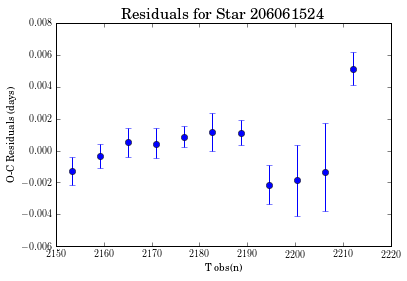

************************ Star 206082454  ************************

  -> Number of observed transits: 2
  -> Observed transit times:
[ 2160.54007257  2190.16616132]

  -> Time diff b/w consecutive transits/period (t/p):
      Transit nº 1 : t/p =  1.0
      Transit nº 2 : t/p =  1.0

  -> Nº of missed Transits:  0.0

  -> 'Observed' t0 (inlcuding missing transits if applicable):
[ 2160.54007257  2190.16616132]

  -> Error of observed t0 (note: 0.0 values correspond to missing transits):
[ 0.00109768  0.00162829]

Check that  vectors n and tobs have same length: 2 2
  -> Initial Guesses (from linear fit of observed t0):
        Period =  29.62608875 days
        t0 =  2160.54007257

perr:  [ 0.  0.]
  -> Optimal Values:

        Period =  29.62608875 +/- 0.0
        Transit Time =  2160.54007257 +/- 0.0
 
Length of 'upper' & 'lower' error 2 2


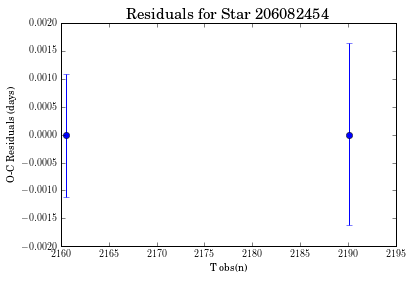

************************ Star 206155547  ************************

  -> Number of observed transits: 3
  -> Observed transit times:
[ 2152.88398612  2177.27246794  2201.6584774 ]

  -> Time diff b/w consecutive transits/period (t/p):
      Transit nº 1 : t/p =  1.0
      Transit nº 2 : t/p =  1.0
      Transit nº 3 : t/p =  1.0

  -> Nº of missed Transits:  0.0

  -> 'Observed' t0 (inlcuding missing transits if applicable):
[ 2152.88398612  2177.27246794  2201.6584774 ]

  -> Error of observed t0 (note: 0.0 values correspond to missing transits):
[ 0.00023176  0.00046688  0.00046338]

Check that  vectors n and tobs have same length: 3 3
  -> Initial Guesses (from linear fit of observed t0):
        Period =  24.38724564 days
        t0 =  2152.88439818

perr:  [ 0.00057381  0.0005238 ]
  -> Optimal Values:

        Period =  24.387420177 +/- 0.000573811777665
        Transit Time =  2152.88410258 +/- 0.000523798635644
 
Length of 'upper' & 'lower' error 3 3


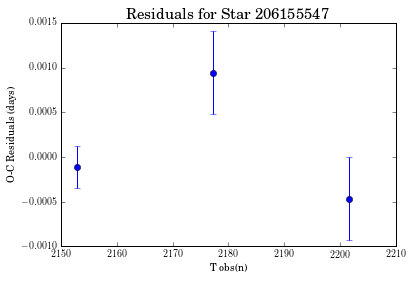

************************ Star 206245553  ************************

  -> Number of observed transits: 8
  -> Observed transit times:
[ 2154.67383798  2162.17100717  2169.66301072  2177.16816729  2184.65590712
  2192.14529046  2199.64642711  2207.14025114]

  -> Time diff b/w consecutive transits/period (t/p):
      Transit nº 1 : t/p =  1.0
      Transit nº 2 : t/p =  1.0
      Transit nº 3 : t/p =  1.0
      Transit nº 4 : t/p =  1.0
      Transit nº 5 : t/p =  1.0
      Transit nº 6 : t/p =  1.0
      Transit nº 7 : t/p =  1.0
      Transit nº 8 : t/p =  1.0

  -> Nº of missed Transits:  0.0

  -> 'Observed' t0 (inlcuding missing transits if applicable):
[ 2154.67383798  2162.17100717  2169.66301072  2177.16816729  2184.65590712
  2192.14529046  2199.64642711  2207.14025114]

  -> Error of observed t0 (note: 0.0 values correspond to missing transits):
[ 0.00195041  0.00369166  0.00131456  0.00401452  0.00316523  0.00405639
  0.00468124  0.00292194]

Check that  vectors n and tobs have

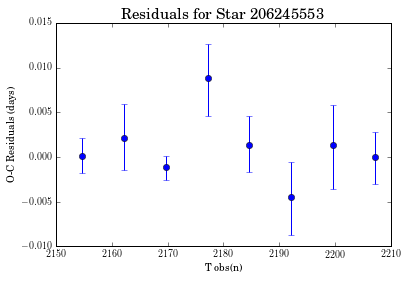

In [29]:
count = 1

for star in new_targets:
    if star.name!="205924614":
        t0 = np.loadtxt('2_'+star.name+'t0_mcmc.txt', skiprows=1)
        t0_obs = t0[:,0]
        t0_uppererr = t0[:,1]       
        t0_lowererr = t0[:,2]
        print "************************ Star", star.name, " ************************"
        print ""
        print "  -> Number of observed transits:", len(star.transits)
        print "  -> Observed transit times:"
        print t0_obs
        print ""
        opt_values, err = oc(star, t0_obs, t0_uppererr, t0_lowererr)
        
        np.savetxt('3_'+star.name+'finalp0t0.txt', np.transpose([opt_values,err]), fmt='%.10f', 
                      delimiter = ' ', header = """Column 1 shows the period (row 1) and its uncertainty (row 2). 
                       Column 2 gives t0 (row 1) and its uncertainty (row 2). Light curves with only two
                       transits have uncertainties equal to 0.0. This is NOT because 0.0 is their 
                       actual value, but because we couldn't calculate it with only two points.
                       """) 
        
        count += 1

Mirror: Fold the folded LC again (goal: see what's happening with target 205924614)

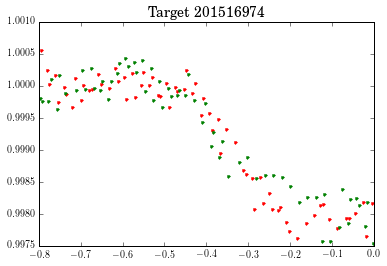

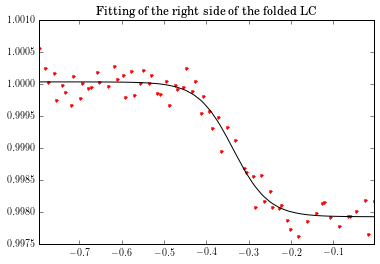

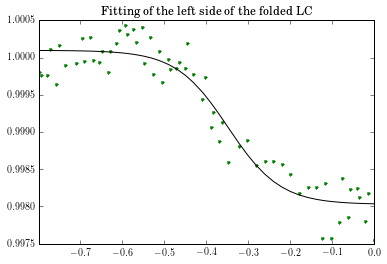

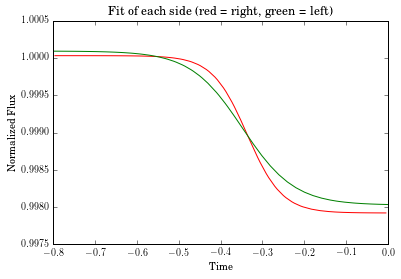

-----------------------------------------------


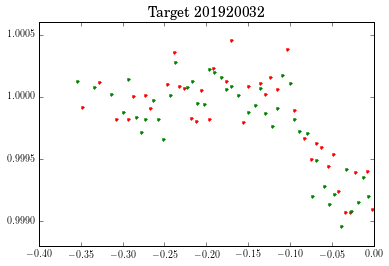

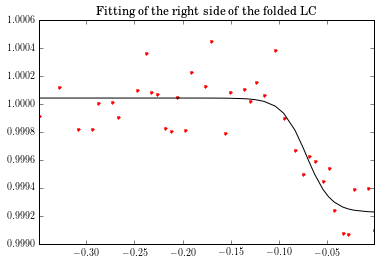

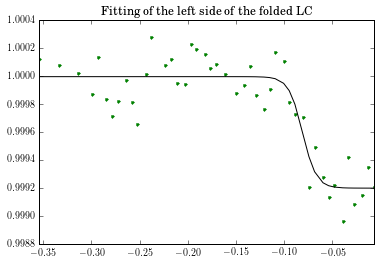

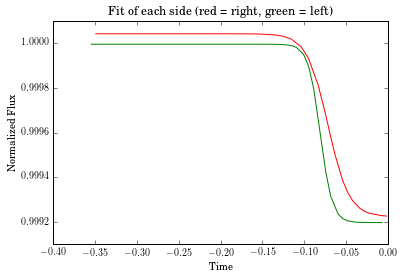

-----------------------------------------------


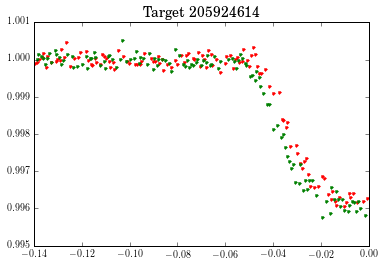

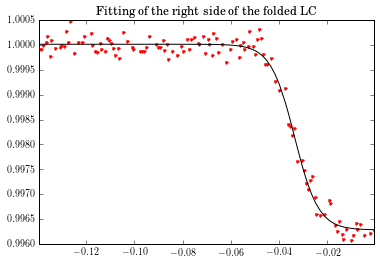

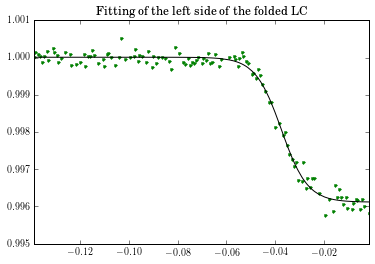

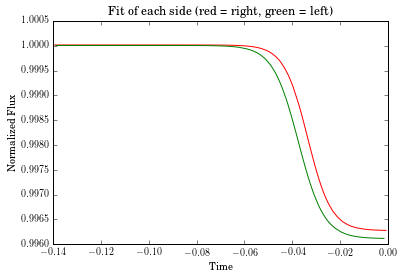

-----------------------------------------------


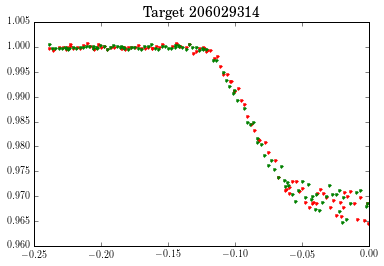

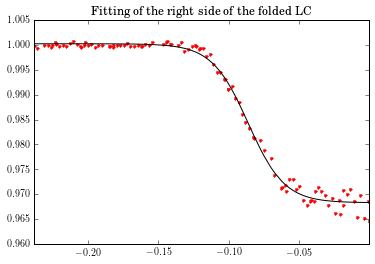

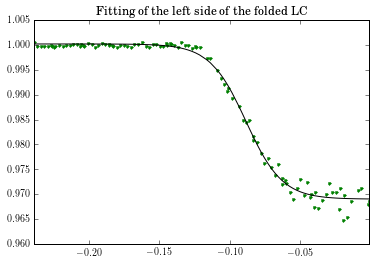

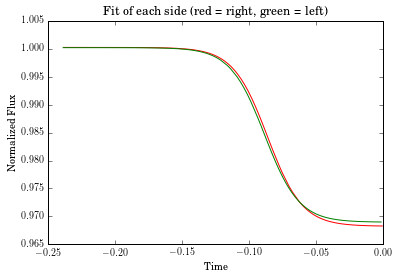

-----------------------------------------------


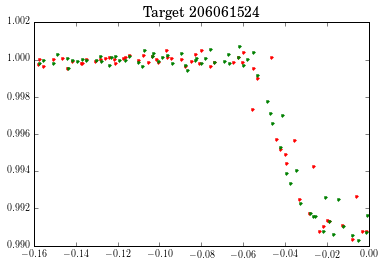

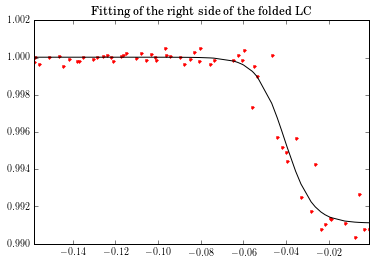

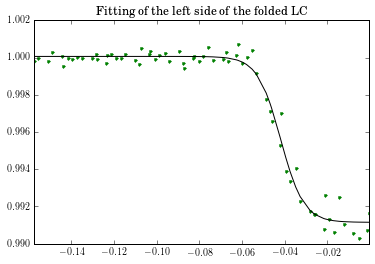

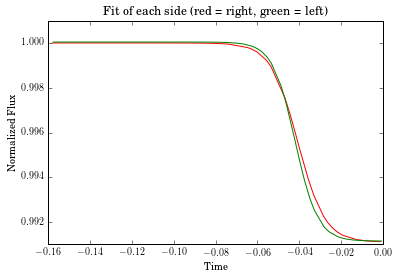

-----------------------------------------------


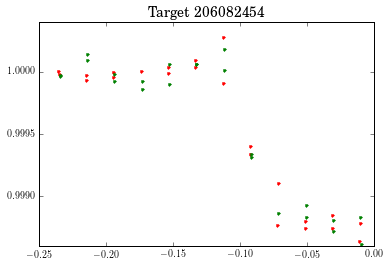

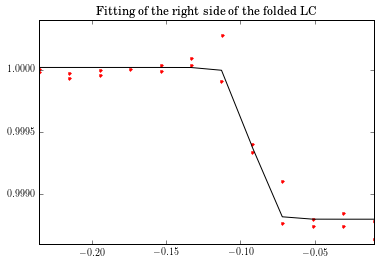

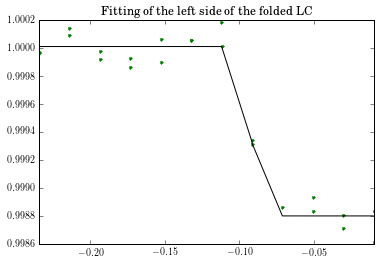

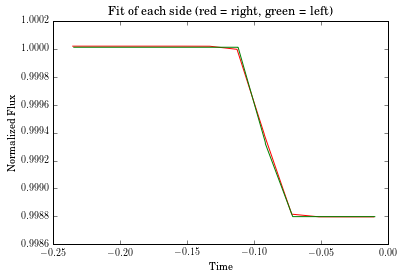

-----------------------------------------------


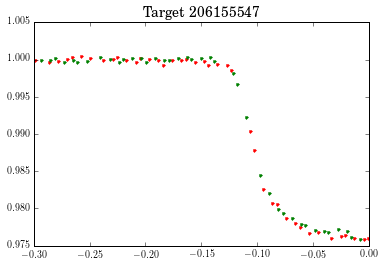

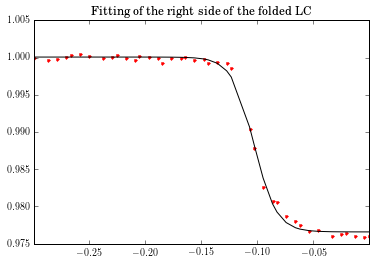

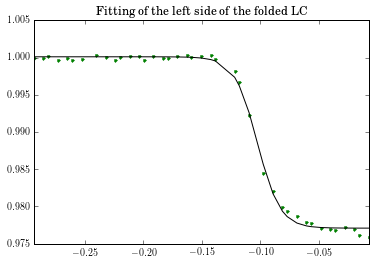

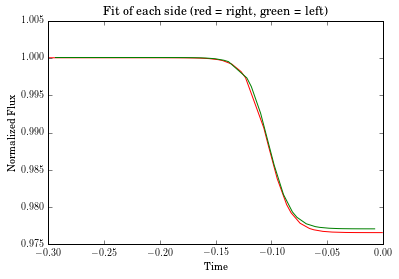

-----------------------------------------------


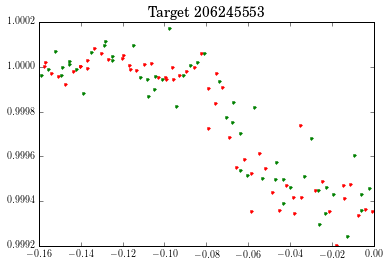

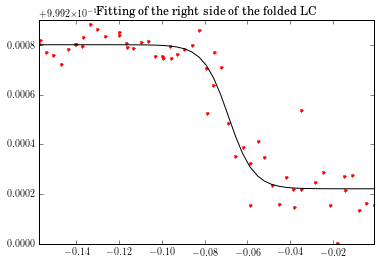

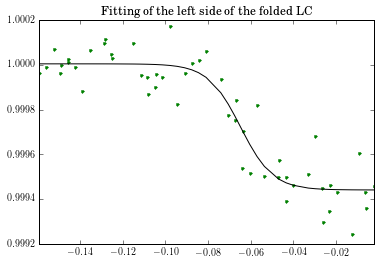

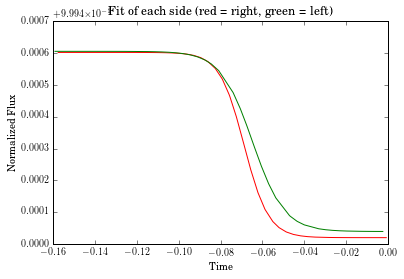

-----------------------------------------------


In [30]:
def my_fit(x, amp, b, h_offset, v_offset):
    return amp*np.tanh(b*x + h_offset) + v_offset 
    #return np.tanh(x)

def initialParams(x, y):
    amplitude = np.max(y)-np.min(y)
    b = 1.0
    horizontal_offset = x[np.argmin(y)] #queremos la posición del valor del flujo más pequeño
    vertical_offset = np.min(y) #valor mínimo del flujo
    return [amplitude, b, horizontal_offset, vertical_offset] 

for star in new_targets: 
    
    right = np.where(star.dt > 0.0)
    f_right = star.f_trans[right]
    t_right = star.dt[right]*-1
    
    left = np.where(star.dt < 0.0)
    f_left = star.f_trans[left]
    t_left = star.dt[left]
    
    plt.figure(1)
    plt.plot(t_right, f_right, '.', c = 'r')
    plt.plot(t_left, f_left, '.', c = 'g')
    plt.title('Target '+star.name, fontsize = 14)
    plt.plot()
    
    x1 = t_right
    y1 = f_right
    
    x2 = t_left
    y2 = f_left
    
    p0_right = initialParams(x1, y1)
    p0_left = initialParams(x2, y2)
    
    popt_right, pcov_right = curve_fit(my_fit, x1, y1, p0 = p0_right) #Algorithm uses the Levenberg-Marquardt algorithm through leastsq. 
    popt_left, pcov_left = curve_fit(my_fit, x2, y2, p0 = p0_left)
    
    argsorts_right = np.argsort(x1) #Ordena el vector x1
    argsorts_left = np.argsort(x2) #Ordena el vector x2
    
    ypred_right = my_fit(x1, *popt_right)
    ypred_left = my_fit(x2, *popt_left)
    
    plt.figure(2)
    plt.title("Fitting of the right side of the folded LC", fontsize = 12)
    plt.plot(x1, y1, '.', c = 'r')
    plt.plot(x1[argsorts_right], ypred_right[argsorts_right], '-', c = 'k')
    plt.xlim(np.min(x1), np.max(x1))
    
    plt.figure(3)
    plt.title("Fitting of the left side of the folded LC", fontsize = 12)
    plt.plot(x2, y2, '.', c = 'g')
    plt.plot(x2[argsorts_left], ypred_left[argsorts_left], '-', c = 'k')
    plt.xlim(np.min(x2), np.max(x2))
       
    plt.figure(4)
    plt.title("Fit of each side (red = right, green = left)", fontsize = 12)
    plt.plot(x1[argsorts_right], ypred_right[argsorts_right], '-', c = 'r')
    plt.plot(x2[argsorts_left], ypred_left[argsorts_left], '-', c = 'g')
    plt.xlabel('Time')
    plt.ylabel('Normalized Flux')
    plt.savefig('3_'+star.name+'fold_foldLC.png', dpi=800)
    plt.show()
    print "-----------------------------------------------"